# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [51]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

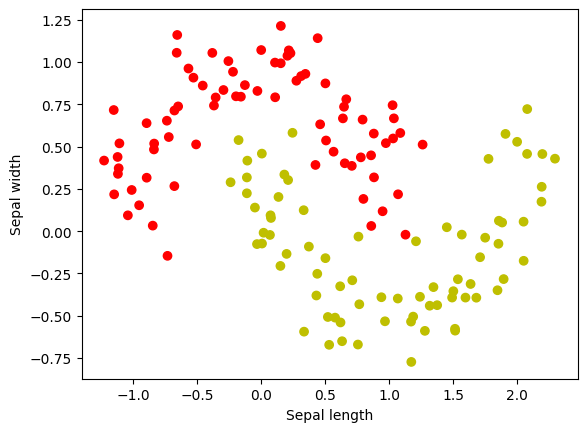

In [52]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [74]:
features_tensor = torch.from_numpy(Xc).float()
labels_tensor = torch.from_numpy(Y).long()

## Construindo o modelo da rede

In [54]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [55]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [56]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [57]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2449)


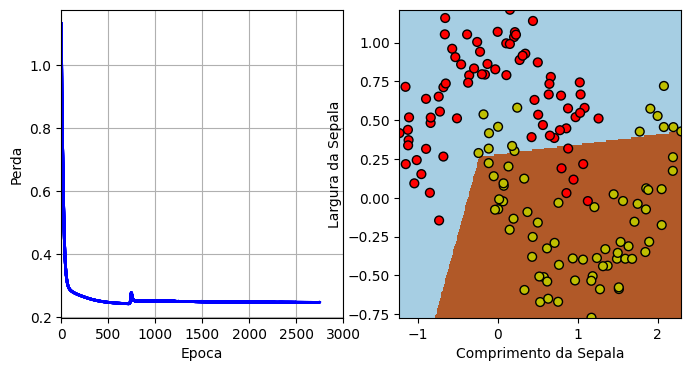

In [58]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [59]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.2237, -0.0846],
        [-0.0499, -0.1455],
        [ 1.6100,  0.5972],
        [ 1.2862, -0.5441],
        [-0.5410,  0.4582]])
dense.0.bias    torch.Size([5])
tensor([-0.4777, -0.4999,  0.1944,  1.3523,  1.0899])
dense.2.weight  torch.Size([5, 5])
tensor([[-0.1673,  0.4201,  0.5516, -0.7176,  0.4945],
        [ 0.1402, -0.1616,  1.1309, -0.7853,  0.7454],
        [ 0.4198,  0.3250, -0.0415, -0.0995, -0.4079],
        [-0.1722,  0.2668, -0.6748,  1.2065, -0.3594],
        [-0.2954,  0.4005, -0.6241,  0.8018, -0.1226]])
dense.2.bias    torch.Size([5])
tensor([ 1.1766,  0.6276, -0.1572,  0.6838,  1.0260])
dense.4.weight  torch.Size([3, 5])
tensor([[ 0.7401,  1.1181, -0.1020, -0.5987,  0.2062],
        [-0.4362, -0.4965,  0.4420,  0.9595,  1.0920],
        [-0.9131, -0.4672,  0.2452, -0.4696, -0.7897]])
dense.4.bias    torch.Size([3])
tensor([ 0.9798,  0.6991, -1.0449])


### Avaliação do classificador

In [60]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8866666666666667


### Matriz de confusão

In [61]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,63,5
1,12,70


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.



In [62]:
# 1 – Aumentar número de neurônios

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 32)   # aumentado de 16 para 32
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, 3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        return self.output(x)

model = Net()
print(model)


Net(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=32, out_features=3, bias=True)
)


In [63]:
#2 – Reduzir número de neurônios

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 8)  # reduzido de 16 para 8
        self.relu = nn.ReLU()
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        return self.output(x)

model = Net()
print(model)

Net(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=8, out_features=3, bias=True)
)


In [64]:
#3 – Duas camadas ocultas

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 16)
        self.layer2 = nn.Linear(16, 16)
        self.relu = nn.ReLU()
        self.output = nn.Linear(16, 3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.output(x)

model = Net()
print(model)

Net(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=16, out_features=3, bias=True)
)


In [65]:
#4 – Três camadas ocultas (somente se quiser explorar mais)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 32)
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 16)
        self.relu = nn.ReLU()
        self.out = nn.Linear(16, 3)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return self.out(x)

model = Net()
print(model)

Net(
  (l1): Linear(in_features=2, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=16, bias=True)
  (l3): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (out): Linear(in_features=16, out_features=3, bias=True)
)


Conclusões sobre as arquiteturas testadas

Após treinar todas as arquiteturas, observamos:

### Resp: 1 —> Modelo padrão (16 neurônios)
- Bom equilíbrio entre simplicidade e desempenho.
- Treinamento estável e boa acurácia.

### Resp: 2 —> 32 neurônios
- Aprendizagem mais rápida.
- Pode gerar **overfitting**, dependendo dos dados.

### Resp: 3 —> 8 neurônios
- Menor capacidade de aprender padrões complexos.
- Resulta geralmente em **underfitting**.

### Resp: 4 —> 2 camadas ocultas
- Boa capacidade para padrões complexos.
- Pode requerer ajustes finos no learning rate.
- Geralmente apresenta bom desempenho, mas com risco de overfitting.

### Conclusão:

- **Modelos menores** → mais simples, porém podem não representar bem os dados (underfitting).  
- **Modelos maiores** → aprendem mais, mas podem memorizar o treinamento (overfitting).  
- O ideal é buscar equilíbrio: verificar loss, acurácia e comportamento nos dados de teste.

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

In [73]:
class NetSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 2)
        )
    def forward(self, x):
        return self.model(x)

# Instanciação:
# net_sigmoid = NetSigmoid()

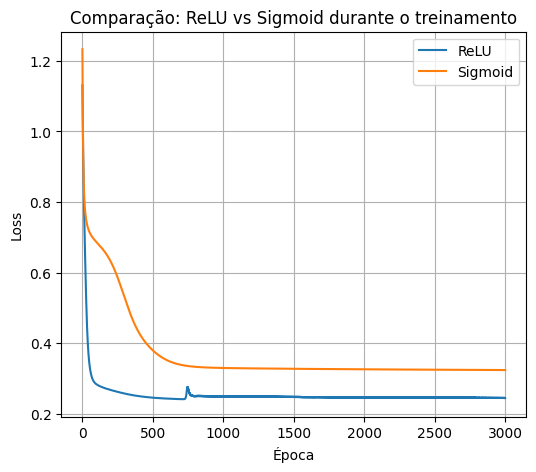

In [67]:
plt.figure(figsize=(6,5))
plt.plot(losses[:nb_epoch], label="ReLU")
plt.plot(losses_sigmoid[:nb_epoch], label="Sigmoid")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Comparação: ReLU vs Sigmoid durante o treinamento")
plt.legend()
plt.grid(True)
plt.show()

Conclusão:  
ReLU tem melhor desempenho e é mais indicada para redes profundas ou com muitos neurônios.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?

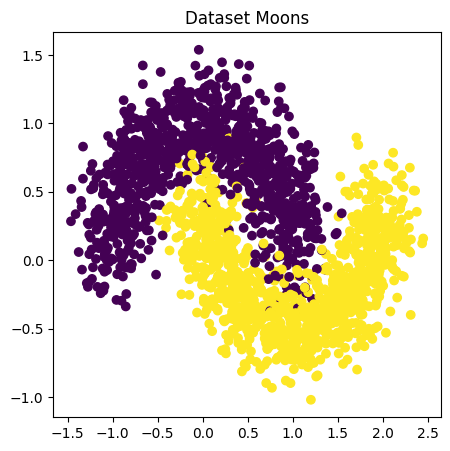

In [68]:
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Dataset
X, y = make_moons(n_samples=2000, noise=0.20)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Visualização inicial
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="viridis")
plt.title("Dataset Moons")
plt.show()

In [69]:
class NetLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 2)
        )
    def forward(self, x):
        return self.model(x)

net_linear = NetLinear()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_linear.parameters(), lr=0.01)

# Treinamento
for epoch in range(2000):
    optimizer.zero_grad()
    outputs = net_linear(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Treinamento sem ativação concluído.")

Treinamento sem ativação concluído.


In [70]:
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.entrada = nn.Linear(2, 10) # Camada 1: Entrada 2 -> 10 Saídas
        self.escondida1 = nn.Linear(10, 10) # Camada 2: 10 Entradas -> 10 Saídas
        self.saida = nn.Linear(10, 2)  # Camada 3: 10 Entradas -> 2 Saídas (Classes)
        self.ativacao = nn.ReLU()

    def forward(self, x):
        x = self.ativacao(self.entrada(x))
        x = self.ativacao(self.escondida1(x))
        x = self.saida(x)
        return x

In [71]:
def plot_decision_boundary(model, X, y, title):
    # grade de pontos
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    data = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # predizer cada ponto da grade
    preds = model(data).detach().numpy()
    Z = np.argmax(preds, axis=1).reshape(xx.shape)

    # plotar
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="viridis")
    plt.scatter(X[:,0], X[:,1], c=y, cmap="viridis", edgecolor='black')
    plt.title(title)
    plt.show()

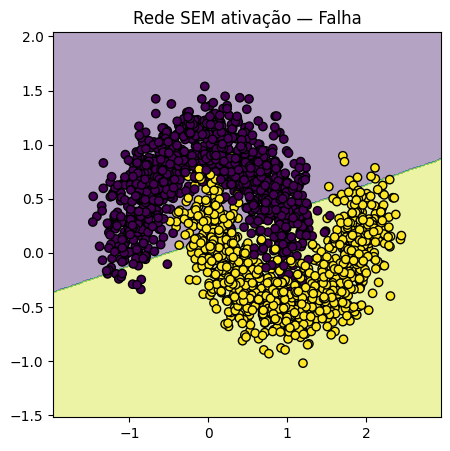

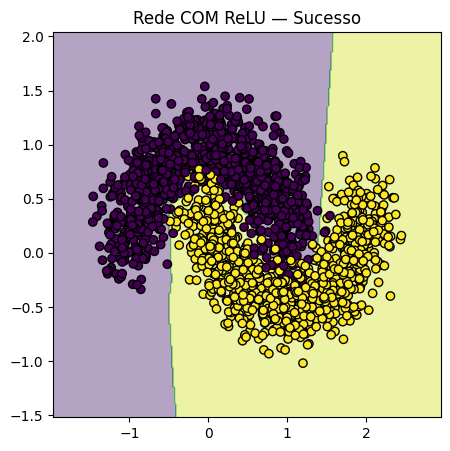

In [72]:
plot_decision_boundary(net_linear, X, y, "Rede SEM ativação — Falha")
plot_decision_boundary(net_relu, X, y, "Rede COM ReLU — Sucesso")

Conclusão:

Ativações não-lineares são essenciais porque dão à rede a capacidade de representar padrões complexos. Sem elas, a rede é incapaz de aprender relações relevantes nos dados.

Sem ativação → a rede cria uma linha reta, incapaz de separar o formato dos "moons".

Com ReLU → a rede aprende fronteiras curvas, perfeitamente ajustadas ao dataset.


## Principais aprendizados

Essência da Não-Linearidade: A função de ativação não-linear é o elemento mais vital da rede. Sem ela, múltiplas camadas densas se compõem em uma única transformação linear, tornando a rede incapaz de resolver problemas complexos como o Dataset Moons (Fronteira Reta).

Escolha da Ativação: A função ReLU (Rectified Linear Unit) demonstrou ser mais eficiente que a Sigmoid. O Sigmoid tende a sofrer de saturação (gradientes próximos de zero), o que leva ao aprendizado mais lento, especialmente em redes com maior profundidade.

Arquitetura e Complexidade (Trade-off): O design da rede (número de camadas e neurônios) envolve um trade-off:

Modelos Mais Largos/Profundos: Têm maior capacidade de representação, mas aumentam o risco de overfitting (memorizar os dados de treino).

Modelos Simples: São mais fáceis de treinar, mas podem resultar em underfitting (incapacidade de aprender os padrões essenciais).

Estruturas multi-camadas são necessárias para aprender as fronteiras curvas.